In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the preprocessed training set
preprocessed_file_path = '/content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/preprocessed_training_set.csv'

data = pd.read_csv(preprocessed_file_path)

In [ ]:
# Inspect unique classes
unique_classes = data['label'].unique()
print("Unique classes in the dataset:", unique_classes)

# Check the count of each class
class_counts = data['label'].value_counts()
print("\nClass counts:")
print(class_counts)

Unique classes in the dataset: [0 1]

Class counts:
label
1    45332
0    37000
Name: count, dtype: int64


In [ ]:
# Check column names to confirm class column
print("Column names in the dataset:", data.columns)


Column names in the dataset: Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label', 'attack_cat'],
      dtype='object')


<ipython-input-10-1faac2352b1b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='tab10')


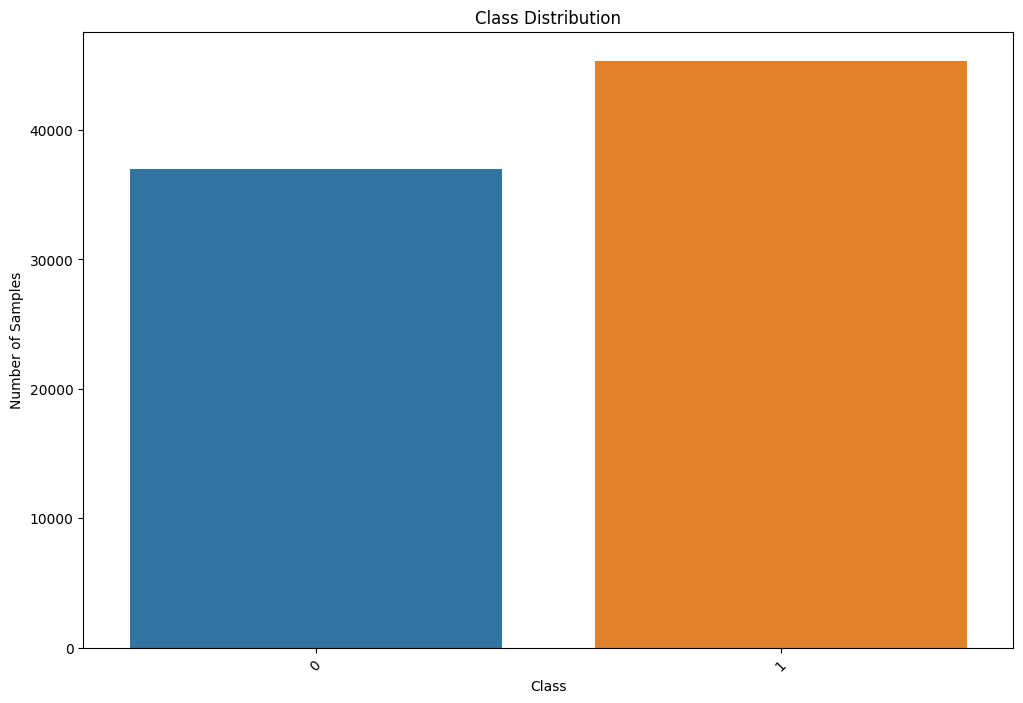

In [ ]:

# Assuming the class column is named 'label'
class_counts = data['label'].value_counts()

# Visualize class distribution for all classes
plt.figure(figsize=(12, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='tab10')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate class labels if there are many
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        dur     proto   service     state     spkts     dpkts    sbytes  \
0 -0.213727  0.410563 -0.674406  0.932695 -0.124455 -0.151816 -0.043684   
1 -0.213728  0.410563 -0.674406  0.932695 -0.124455 -0.151816 -0.036308   
2 -0.213729  0.410563 -0.674406  0.932695 -0.124455 -0.151816 -0.040351   
3 -0.213729  0.410563 -0.674406  0.932695 -0.124455 -0.151816 -0.041330   
4 -0.213728  0.410563 -0.674406  0.932695 -0.124455 -0.151816 -0.034187   

     dbytes      rate     sttl  ...  ct_dst_sport_ltm  ct_dst_src_ltm  \
0 -0.087369  0.057181  0.71944  ...         -0.450186       -0.477994   
1 -0.087369  0.286565  0.71944  ...         -0.450186       -0.477994   
2 -0.087369  0.791209  0.71944  ...         -0.450186       -0.390391   
3 -0.087369  0.566923  0.71944  ...         -0.450186       -0.390391   
4 -0.087369  0.118350  0.71944  ...         -0.450186  

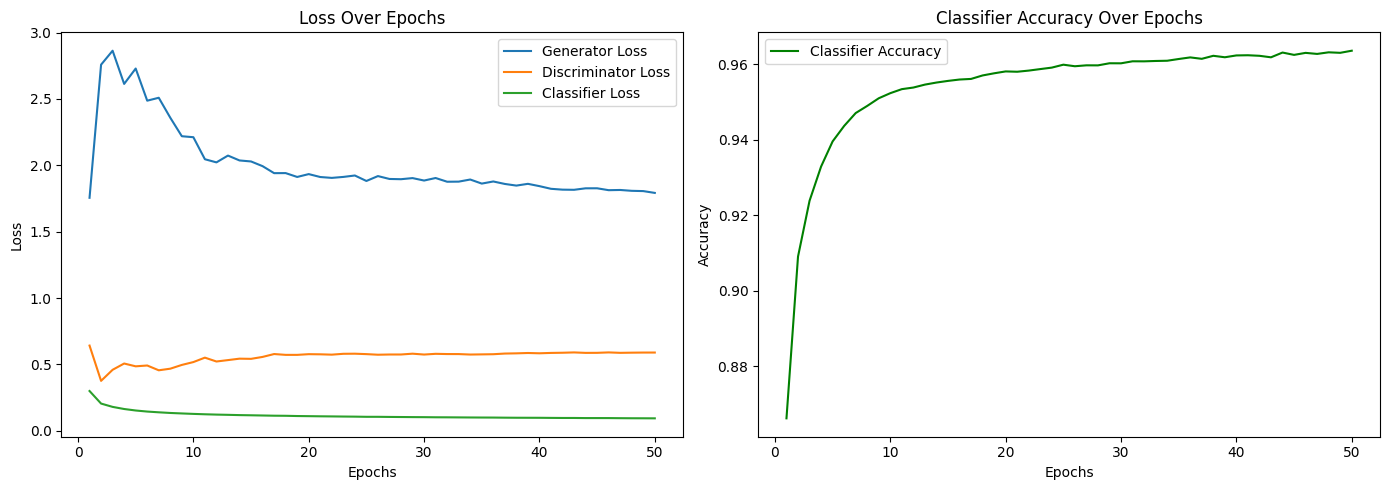

Models saved successfully!


<ipython-input-16-1f27c172ba1e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/drive/MyDrive/tmg_gan_models_generator.pth')

RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for model.4.weight: copying a param with shape torch.Size([42, 256]) from checkpoint, the shape in current model is torch.Size([43, 256]).
	size mismatch for model.4.bias: copying a param with shape torch.Size([42]) from checkpoint, the shape in current model is torch.Size([43]).

In [ ]:
#Load the Trained Generator
%run "/content/drive/MyDrive/Colab Notebooks/Training the TMG-GAN model.ipynb"

# Define the dimensions of the input and output
z_dim = 42  # Same as during training
input_dim = data.shape[1] - 1  # Exclude the label column

# Load the generator
generator = Generator(input_dim=z_dim, output_dim=input_dim)
generator.load_state_dict(torch.load('/content/drive/MyDrive/tmg_gan_models_generator.pth'))
generator.eval()

In [ ]:
#Generate Synthetic Samples
# Target number of samples per class (equal to the majority class count)
target_samples = class_counts.max()

# Generate synthetic samples
synthetic_data = []

for class_label, count in class_counts.items():
    if count < target_samples:
        num_to_generate = target_samples - count
        z = torch.randn(num_to_generate, z_dim)
        synthetic_samples = generator(z).detach().numpy()
        synthetic_labels = np.full((num_to_generate,), class_label)
        synthetic_data.append(pd.DataFrame(synthetic_samples, columns=data.columns[:-1]))
        synthetic_data[-1]['label'] = synthetic_labels

# Combine original and synthetic data
synthetic_df = pd.concat(synthetic_data, ignore_index=True)
balanced_data = pd.concat([data, synthetic_df], ignore_index=True)

In [ ]:
#Visualize Class Distribution After Balancing

balanced_class_counts = balanced_data['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Balancing')
plt.show()


In [ ]:
#Save the Balanced Dataset
balanced_file_path = '/content/drive/MyDrive/Datasets/UNSW-NB15/MyTechniques/balanced_training_set.csv'
balanced_data.to_csv(balanced_file_path, index=False)
print(f"Balanced dataset saved to {balanced_file_path}")
